In [1]:
import pandas as pd
# Set some Pandas options
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)
import numpy as np
import scipy as sp
import statsmodels.formula.api as smf
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000000 # Jupyter notebook backend restricts number of points in plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.plotly as py
from plotly.graph_objs import Figure,Layout,Scatter,Bar
from time import time
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler,scale,binarize
from sklearn.feature_selection import SelectKBest,mutual_info_classif,chi2,RFE,RFECV,SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,cross_validate,StratifiedKFold,KFold,GridSearchCV,RandomizedSearchCV

### Creación de funciones

* La función plot_pie fué extraída de un notebook en Kaggle (espero encontrarla pronto para agregar la referencia=

* El resto de las funciones fueron creadas por mi para simplificarme algunas tareas repetitivas y/o que la función em entregue la interpretación del test directamente

In [2]:
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')
    
def transformacion_logaritmica(x):
    if(x==0):
        return 0
    else:
        return np.log(x)
    
def expected_values(var1,var2):
    contingencyTable = pd.crosstab(index=var1,columns=var2,margins=True)
    expected =  np.outer(contingencyTable.iloc[0:(len(contingencyTable.index)-1)]['All'],
                         contingencyTable.loc["All"][0:(len(contingencyTable.columns)-1)]/contingencyTable.loc["All"]['All'])
    expected = pd.DataFrame(expected)
    expected.columns = contingencyTable.columns[0:(len(contingencyTable.columns)-1)]
    expected.index = contingencyTable.index[0:(len(contingencyTable.index)-1)]
    return expected

def chi2_test(var1,var2,alpha=0.95):
    #Creamos la tabla de contingencia con los valores totales
    contingencyTable = pd.crosstab(index=var1,columns=var2,margins=True)
    #Creamos la tabla de valores esperados
    expected =  np.outer(contingencyTable.iloc[0:(len(contingencyTable.index)-1)]['All'],
                         contingencyTable.loc["All"][0:(len(contingencyTable.columns)-1)]/contingencyTable.loc["All"]['All'])
    expected = pd.DataFrame(expected)
    expected.columns = contingencyTable.columns[0:(len(contingencyTable.columns)-1)]
    expected.index = contingencyTable.index[0:(len(contingencyTable.index)-1)]
    #Creamos la tabla de contingencia sin los valores totales
    contingencyTable = pd.crosstab(index=var1,columns=var2)
    #calculamos el valor calculado de chi2
    chi_squared_stat = (((contingencyTable-expected)**2)/expected).sum().sum()
    #calculamos los grados de libertad
    dof=(len(contingencyTable.columns)-1)*(len(contingencyTable.index)-1)
    #calculamos el valor crítico de chi2
    crit = sp.stats.chi2.ppf(q = alpha,df = dof)
    #calulamos el p-valor
    p_value = 1 - sp.stats.chi2.cdf(x=chi_squared_stat,df=dof)
    #testeamos la hipótesis nula de independencia entre las variables
    if(chi_squared_stat<=crit):
        print('no hay evidencia suficiente para rechazar H0, los valores son independientes y el p-valor es: {}'
              '\n el p-valor es:'.format(round(p_value,4)))
        print("los valores esperados son: "+ str(expected))
    else:
        print('Se rechaza H0, no hay evidencia para decir que los valores son independientes'
              '\n y el p-valor es: {}'.format(round(p_value,4)))
        print("los valores esperados son: "+ str(expected))

In [3]:
df=pd.read_csv("data_hr.csv",encoding='utf-8',sep=',')
print(df.shape)
df.head()

(14999, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Diccionario de variables

* Hay 14.999 registros y 10 variables, incluyendo el target. Cada registro corresponde a la información de un empleado.

* SL: Satisfacción del empleado con la compañia
* LE: last proyect evaluation
* NP: Número de proyectos en los que el empleado a trabajado durante el tiempo en la empresa
* AMH: Número de horas promedio trabajadas por el empleado en los últimos 12 meses 
* TSC: Tempo que ha estado en la compañia (en años)
* WA: Accidentes en el trabajo
* PL5Y: Promociones en los últimos 5 años
* Sales: Cada valor representa el nombre del departamento al cual pertenece el individuo
* Salary: Salario en rango (bajo, medio y alto)
* left: Es la variable target y nos indica con un 1 si la persona dejó la compañia y con un 0 cuando no

*Este dataset no toma en cuenta las personas que han sido despedidas, transferidas o contratatas durante el último año*

* A continuación mostramos los tipos de datos de cada una de las variables

In [4]:
df.dtypes

satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

## Preguntas de negocio propuestas

1.- Identifique cuáles son las variables que impactan en mayor medida que los mejores empleados dejen la compañia e interprete sus resultados como si tuviera que presentar el informe a un reclutador

2.- Proponer la forma de utilizar estos datos para efectuar acciones personalizadas y preventivas sobre los empleados sus descrubrimientos para disminuir la fuga de talentos en la empresa


## Preguntas técnicas propuestas

1.-Explique claramente cuál fue la metodología utilizada para determinar cuáles eran las variables que más impactan en la fuga de talentos

2.-Explique cómo seleccionó el modelo adecuado para resolver el problema y cómo controlo el sobreajuste en este proceso

## EDA

* Partimos el análisis haciendo un EDA (análisis exploratorio de datos) en donde comprenderemos la cantidad de valores NA's, distribución, relación con la variable target y correlaciones de cada una de las variables target

* Para esto utilizaremos las siguientes herramientas:
    * Histogramas
    * Boxplot (individuales y por categoría de la variable target)
    * Gráficos barra (individuales y por categoría de la variable target)
    * Gráficos de torta
    * Medidas de tendencia central (media, desviación estandar, mediana, percentiles)
    * Test Chi-2 para las variables categóricas no ordinales
    * Cálculo de la cantidad de NAs y el porcentaje de estos sobre el total de datos


* Fuentes para hacer los gráficos:

*<http://nbviewer.jupyter.org/gist/fonnesbeck/5850463>*

*<https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.boxplot>*

*<https://plot.ly/python/bar-charts/>*
    
    
**¿Por qué no hacer test ANOVA para las variables númericas?  porque el test Anova requiere el cumplimiento de 3 supuestos muy fuertes:**

    1.-Normalidad en la distribución de la variable numérica para cada valor de la categoría
    2.-Homogeneidad de la varianza en la variable numérica para cada categoría
    3.-Aleatoriedad de la muestra

**Para nuestras variables, es claro que estos supuestos no se cumplen y por lo tanto la aplicación del test conduciría a conclusiones equivocadas**
<https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide-2.php>


In [5]:
value_list = []
missing_list = []
columns=df.columns
for col in columns:
    value_list.append((df[col].notnull()).sum())
    missing_list.append((df[col].isnull()).sum())

trace1 = Bar(
    x=columns,
    y=value_list ,
    name='Actual Values'
)
trace2 = Bar(
    x=columns,
    y=missing_list,
    name='Missing Values'
)

data = [trace1, trace2]
layout = Layout(
    barmode='stack',
    title='Count of missing values in continuous variables'
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

Información del dataset:
 las clases del target son: Counter({0: 11428, 1: 3571})


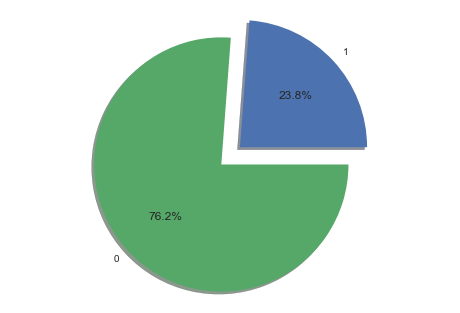

In [6]:
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(df.left)))
plot_pie(df.left)

### Satisfaction level

count    14999.000000
mean         0.612834
std          0.248631
min          0.090000
25%          0.440000
50%          0.640000
75%          0.820000
max          1.000000
Name: satisfaction_level, dtype: float64


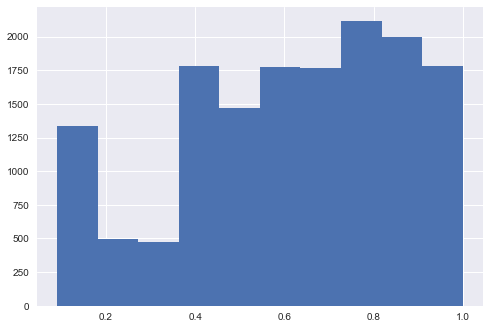

In [7]:
print(df['satisfaction_level'].describe())
df['satisfaction_level'].hist();

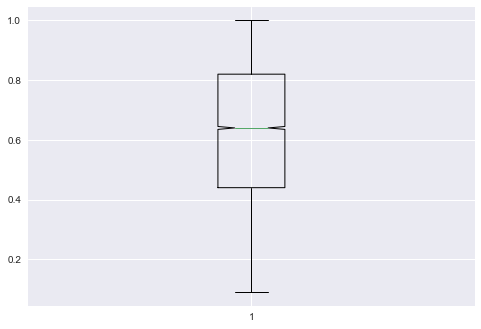

In [8]:
plt.boxplot(df.satisfaction_level,'rs');

        count      mean       std   min   25%   50%   75%   max
left                                                           
0     11428.0  0.666810  0.217104  0.12  0.54  0.69  0.84  1.00
1      3571.0  0.440098  0.263933  0.09  0.13  0.41  0.73  0.92


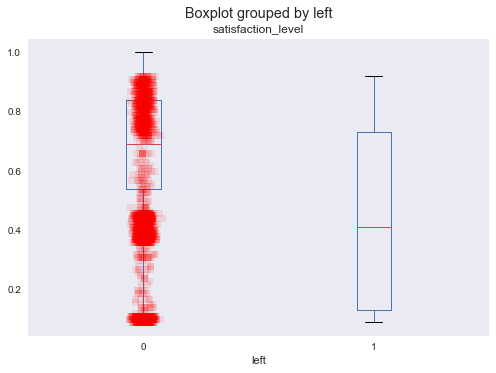

In [9]:
print(df.groupby('left')['satisfaction_level'].describe())
bp = df.boxplot(column='satisfaction_level',by='left',grid=False)
for i in [0,1]:
    y = df.satisfaction_level[df.left==i].dropna()
    x = np.random.normal(i, 0.02, size=len(y))
    plt.plot(x, y, 'rs', alpha=0.1)

### Last evaluation

count    14999.000000
mean         0.716102
std          0.171169
min          0.360000
25%          0.560000
50%          0.720000
75%          0.870000
max          1.000000
Name: last_evaluation, dtype: float64


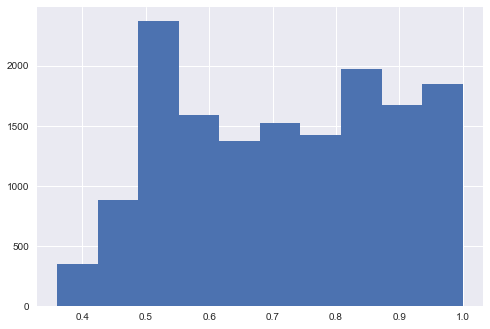

In [10]:
print(df.last_evaluation.describe())
df.last_evaluation.hist();

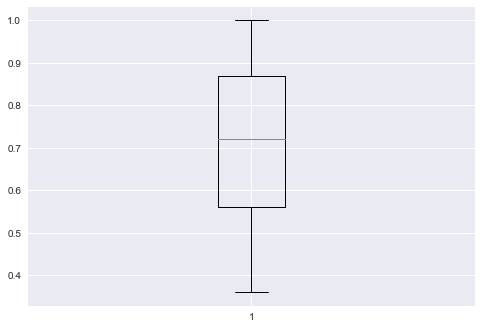

In [11]:
plt.boxplot(df.last_evaluation,0,'rs');

        count      mean       std   min   25%   50%   75%  max
left                                                          
0     11428.0  0.715473  0.162005  0.36  0.58  0.71  0.85  1.0
1      3571.0  0.718113  0.197673  0.45  0.52  0.79  0.90  1.0


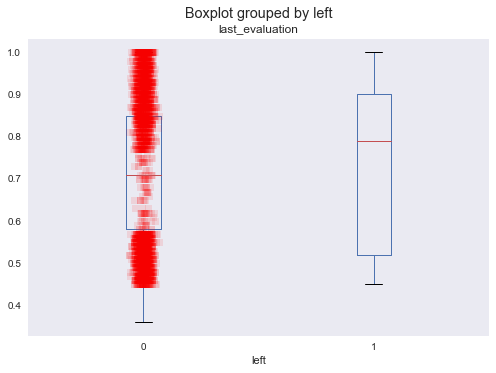

In [12]:
print(df.groupby('left')['last_evaluation'].describe())
bp = df.boxplot(column='last_evaluation',by='left',grid=False)
for i in [0,1]:
    y = df.last_evaluation[df.left==i].dropna()
    x = np.random.normal(i, 0.02, size=len(y))
    plt.plot(x, y, 'rs', alpha=0.1)

### Sales

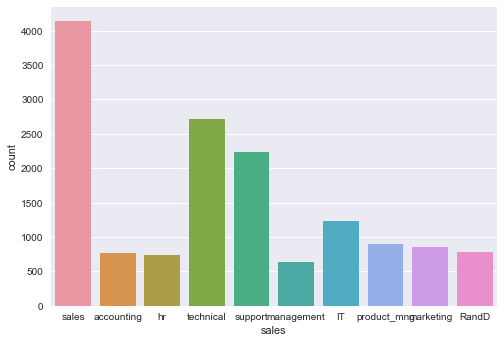

In [13]:
sns.countplot(x='sales', data=df);

sales        IT     RandD  accounting        hr  management  marketing  \
left                                                                     
0      0.777506  0.846252    0.734029  0.709066    0.855556   0.763403   
1      0.222494  0.153748    0.265971  0.290934    0.144444   0.236597   

sales  product_mng     sales   support  technical       All  
left                                                         
0         0.780488  0.755072  0.751009    0.74375  0.761917  
1         0.219512  0.244928  0.248991    0.25625  0.238083  


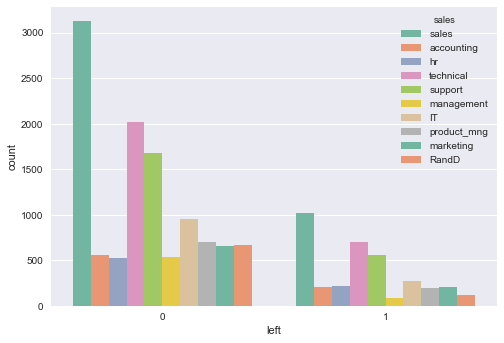

In [14]:
print(pd.crosstab(df.left,df.sales, margins=True,normalize='columns'))
sns.countplot(x='left', hue='sales', data=df, palette='Set2');

In [15]:
pd.crosstab(df.left,df.sales, margins=True,normalize='columns')

sales,IT,RandD,accounting,hr,management,marketing,product_mng,sales,support,technical,All
left,,,,,,,,,,,
0,0.777506,0.846252,0.734029,0.709066,0.855556,0.763403,0.780488,0.755072,0.751009,0.74375,0.761917
1,0.222494,0.153748,0.265971,0.290934,0.144444,0.236597,0.219512,0.244928,0.248991,0.25625,0.238083


In [16]:
chi2_test(var1=df.left,var2=df.sales,alpha=0.99)

Se rechaza H0, no hay evidencia para decir que los valores son independientes
 y el p-valor es: 0.0
los valores esperados son: sales          IT       RandD  accounting          hr  management   marketing  \
left                                                                            
0      934.872725  599.629042  584.390693  563.057004  480.008001  653.725182   
1      292.127275  187.370958  182.609307  175.942996  149.991999  204.274818   

sales  product_mng        sales      support    technical  
left                                                       
0        687.24955  3154.338289  1698.314021  2072.415494  
1        214.75045   985.661711   530.685979   647.584506  


### Salary

In [17]:
pd.crosstab(df.left,df.salary, margins=True,normalize='columns')

salary,high,low,medium,All
left,,,,
0,0.933711,0.703116,0.795687,0.761917
1,0.066289,0.296884,0.204313,0.238083


In [18]:
chi2_test(var1=df.left,var2=df.salary)

Se rechaza H0, no hay evidencia para decir que los valores son independientes
 y el p-valor es: 0.0
los valores esperados son: salary        high          low       medium
left                                        
0       942.491899  5574.188146  4911.319955
1       294.508101  1741.811854  1534.680045


### Número de proyectos

count    14999.000000
mean         3.803054
std          1.232592
min          2.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          7.000000
Name: number_project, dtype: float64


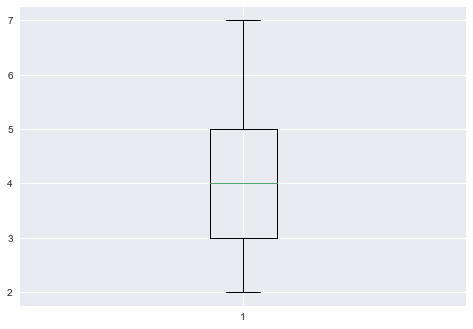

In [19]:
print(df.number_project.describe())
plt.boxplot(df.number_project,0,'rs');

number_project         2         3       4         5         6    7       All
left                                                                         
0               0.343802  0.982244  0.9063  0.778341  0.442078  0.0  0.761917
1               0.656198  0.017756  0.0937  0.221659  0.557922  1.0  0.238083


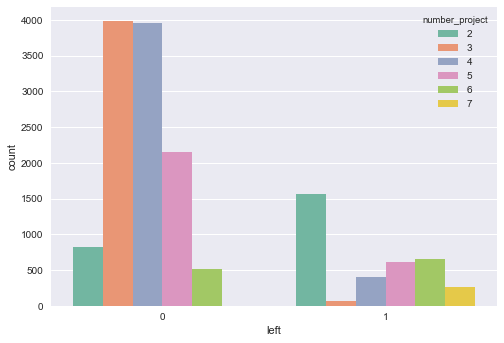

In [20]:
print(pd.crosstab(df.left,df.number_project, margins=True,normalize='columns'))
sns.countplot(x='left', hue='number_project', data=df, palette='Set2');

In [21]:
chi2_test(var1=df.left,var2=df.number_project,alpha=0.99)

Se rechaza H0, no hay evidencia para decir que los valores son independientes
 y el p-valor es: 0.0
los valores esperados son: number_project            2            3            4           5           6  \
left                                                                            
0               1819.458897  3089.575305  3325.769718  2103.65411  894.491099   
1                568.541103   965.424695  1039.230282   657.34589  279.508901   

number_project          7  
left                       
0               195.05087  
1                60.94913  


### Número de horas promedio trabajadas en los últimos 12 meses

count    14999.000000
mean       201.050337
std         49.943099
min         96.000000
25%        156.000000
50%        200.000000
75%        245.000000
max        310.000000
Name: average_montly_hours, dtype: float64


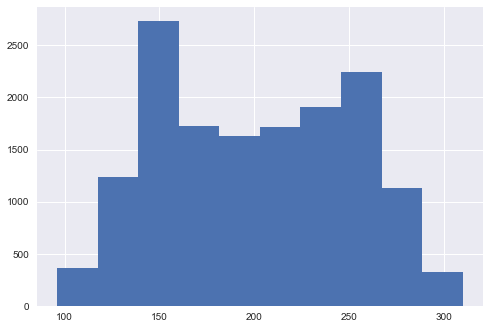

In [22]:
print(df.average_montly_hours.describe())
df.average_montly_hours.hist();

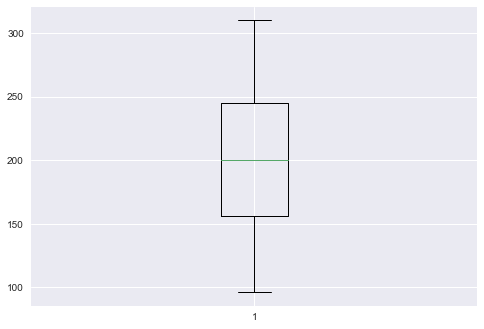

In [23]:
plt.boxplot(df.average_montly_hours,0,'rs');

        count        mean        std    min    25%    50%    75%    max
left                                                                   
0     11428.0  199.060203  45.682731   96.0  162.0  198.0  238.0  287.0
1      3571.0  207.419210  61.202825  126.0  146.0  224.0  262.0  310.0


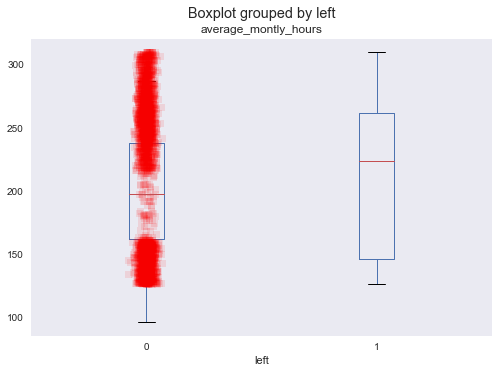

In [24]:
print(df.groupby('left')['average_montly_hours'].describe())
bp = df.boxplot(column='average_montly_hours',by='left',grid=False)
for i in [0,1]:
    y = df.average_montly_hours[df.left==i].dropna()
    x = np.random.normal(i, 0.02, size=len(y))
    plt.plot(x, y, 'rs', alpha=0.1)

count    14999.000000
mean         3.498233
std          1.460136
min          2.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         10.000000
Name: time_spend_company, dtype: float64


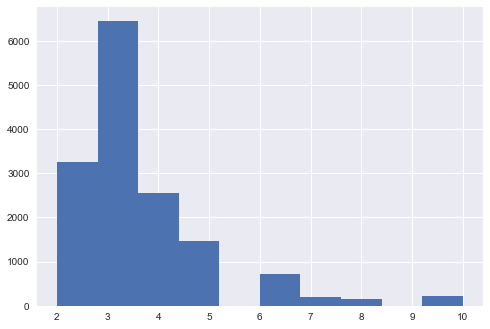

In [25]:
print(df.time_spend_company.describe())
df.time_spend_company.hist();

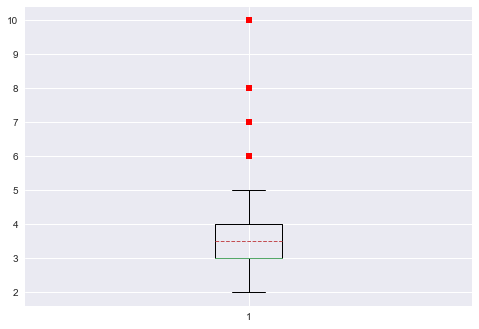

In [26]:
plt.boxplot(df.time_spend_company,0,'rs',vert=True,showmeans=True,meanline=True);

        count      mean       std  min  25%  50%  75%   max
left                                                       
0     11428.0  3.380032  1.562348  2.0  2.0  3.0  4.0  10.0
1      3571.0  3.876505  0.977698  2.0  3.0  4.0  5.0   6.0


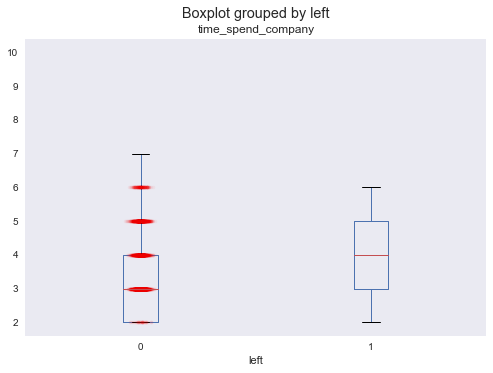

In [27]:
print(df.groupby('left')['time_spend_company'].describe())
bp = df.boxplot(column='time_spend_company',by='left',grid=False)
for i in [0,1]:
    y = df.time_spend_company[df.left==i].dropna()
    x = np.random.normal(i, 0.02, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.05)

### Accidentes en el trabajo

Work_accident        0         1       All
left                                      
0              0.73484  0.922084  0.761917
1              0.26516  0.077916  0.238083


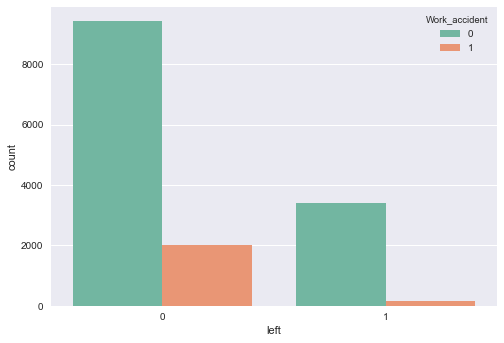

In [28]:
print(pd.crosstab(df.left,df.Work_accident, margins=True,normalize='columns'))
sns.countplot(x='left', hue='Work_accident', data=df, palette='Set2');

In [29]:
chi2_test(df.left,df.Work_accident,alpha=0.99)

Se rechaza H0, no hay evidencia para decir que los valores son independientes
 y el p-valor es: 0.0
los valores esperados son: Work_accident            0            1
left                                   
0              9775.401027  1652.598973
1              3054.598973   516.401027


### Promotion last 5 years

promotion_last_5years         0         1       All
left                                               
0                      0.758038  0.940439  0.761917
1                      0.241962  0.059561  0.238083


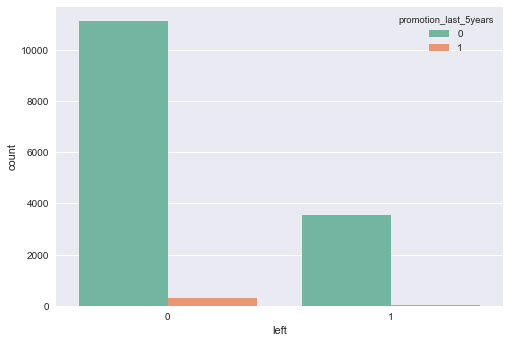

In [30]:
print(pd.crosstab(df.left,df.promotion_last_5years, margins=True,normalize='columns'))
sns.countplot(x='left', hue='promotion_last_5years', data=df, palette='Set2');

In [31]:
chi2_test(var1=df.left,var2=df.promotion_last_5years,alpha=0.99)

Se rechaza H0, no hay evidencia para decir que los valores son independientes
 y el p-valor es: 0.0
los valores esperados son: promotion_last_5years            0          1
left                                         
0                      11184.94833  243.05167
1                       3495.05167   75.94833


### Transformación de variables

* Aplicamos dos transformaciones de variables a las dos variables categóricas que tenemos:

    * Como la variable salario es una variable categórica ordinal, es posible transformarla a número sin perder la 
    naturaleza de lo que representan las categorías bajo, medio, alto.
    
    * Como la variable sales es una variable categórica no ordinal, transformamos todas sus variables en variables 
    dummy, con el objetivo de identificar si es que existe alguna relación entre estar en algún departamento en 
    particular y que la probabilidad de fuga sea más alta o baja
    

* Es importante notar que la variable salario también la pudimos haber transformado en variable dummy para medir el efecto particular de tener un tipo de salario en particular. Sin embargo, el supuesto detrás de no hacerlo es que pensamos que mantener el ordenamiento de sus categorías aporta en la predicción de fuga

In [32]:
df.salary = df.salary.astype('category').cat.reorder_categories(['low', 'medium', 'high'])
salary_numeric = pd.DataFrame(df.salary.cat.codes)
salary_numeric.columns = ['salary']
df = df.drop(['salary'], 1).join(salary_numeric)

In [33]:
sales_dummies = pd.get_dummies(df.sales)
df = df.drop(['sales'], 1).join(sales_dummies)

### Aplicamos el test chi2 sobre las variables categóricas no ordinales

* Las variables categóricas en el dataset son:

    * Sales (no ordinal)
    * promotion_last_5years (binaria)
    * Work_accident (binaria)
    * salary (ordinal)
    
    
* Se aplica un test no paramétrico como el test chi2 para determinar si las categorías de la variable sales son independientes con respecto al target. Luego del cual confirmamos que solo las variables management,hr y RandD no presentan independencia y el resto de las categoría de sales si

*<http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html#sklearn.feature_selection.chi2>*


* En consecuencia, todas las categorías que son independientes con el target en este test son candidatas a ser eliminadas durante la selección de variables ya que no presentan significancia de forma individual. Dado que puede presentar significancia conjunta (en interacción con otras variables) confirmaremos su eliminación utilizando RFE con modelos de SVC lineal, Random Forest y Gradient Boosting

In [34]:
chi2(y=df.left,X=df[['management','hr','RandD','product_mng','IT','marketing','sales','accounting',
                     'support','technical']])

(array([  3.04516067e+01,   1.13793626e+01,   3.08564507e+01,
          1.71479003e+00,   1.64371371e+00,   1.04417630e-02,
          1.06932924e+00,   3.28865914e+00,   1.46206955e+00,
          4.94905082e+00]),
 array([  3.42299713e-08,   7.42645951e-04,   2.77837057e-08,
          1.90365066e-01,   1.99816694e-01,   9.18609877e-01,
          3.01097003e-01,   6.97599693e-02,   2.26601121e-01,
          2.61049970e-02]))

### Aplicamos el test chi2 sobre las variables dummy y categóricas ordinales

* Los resultados nos dicen que se rechaza H0 para las 3 variables evaluadas, por lo que no es posible establecer independencia con el target y todas las variables son candidatas a ser seleccionadas

In [35]:
chi2(y=df.left,X=df[['promotion_last_5years','Work_accident','salary']])

(array([  56.04486528,  306.73771049,  255.27671404]),
 array([  7.08359651e-14,   1.12177164e-68,   1.83702643e-57]))

In [36]:
aux=df.copy()
X = df.drop(['left'], 1).copy()
y = df.left

### Estandarización de valores

* Utilizamos la función StandarScaler() de la librería SkLearn para aplicar el método de estandarización de valores para todas las variables numéricas que tenemos en el dataset (lo cual no incluye a los booleanos que están como 1 o 0) *<http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler>*


* Con un fin explicativo se muestra la variable de horas mensuales promedio trabajada en los últimos 12 meses con y sin escalamiento, en donde podemos ver que la transformación no genera cambios en la distribución de la variable sino que solo modifica los rangos de valores en los que se mueve estableciendo una desviación estandar unitaria (1) y centra la media en 0


* También notamos, que por la misma razón, no cambia la relación lineal entre las variables cuando aplicamos la correlación de pearson frente a otras variables numéricas y por lo tanto obtenemos exactamente los mismos valores para esta métrica


* Ocupamos la estandarización ya que no tenemos presencia importante de outliers en las 5 variables a las cuales aplicaremos la función (revisar boxplots individuales). En caso de que así fuera, se recomienda utilizar otros tipos de escalamiento, en particular el RobusScaler y QuantilScaler son los más usados en esos casos


* Para comprender las diferencias entre los distintos tipos de escalamiento utilizables con SkLearn se recomienda este link:  *<http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html>*

In [37]:
sc = StandardScaler()
aux=X.loc[:,['satisfaction_level', 'last_evaluation','number_project','average_montly_hours','time_spend_company']]
sc.fit(aux)
X_std = sc.transform(aux)
X.loc[:,['satisfaction_level', 'last_evaluation','number_project','average_montly_hours','time_spend_company']]=X_std

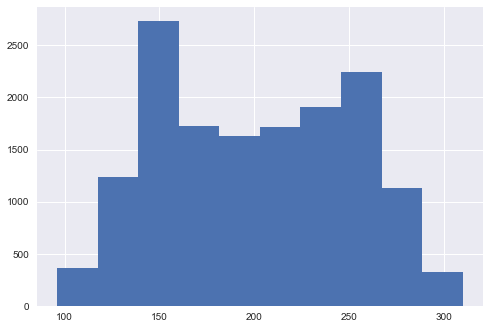

In [38]:
aux.average_montly_hours.hist();

count    1.499900e+04
mean    -4.978720e-16
std      1.000033e+00
min     -2.103471e+00
25%     -9.020633e-01
50%     -2.103137e-02
75%      8.800240e-01
max      2.181549e+00
Name: average_montly_hours, dtype: float64


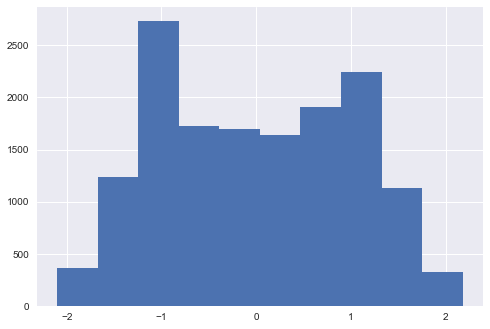

In [39]:
print(X.average_montly_hours.describe())
X.average_montly_hours.hist();

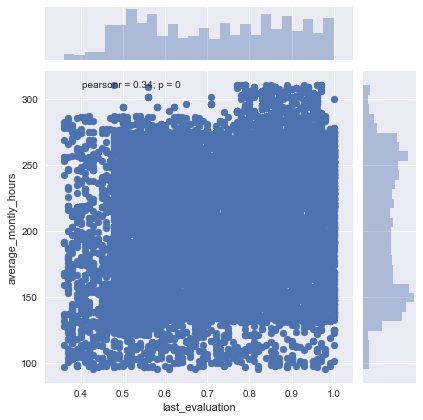

In [40]:
sns.jointplot(aux.last_evaluation,aux.average_montly_hours);

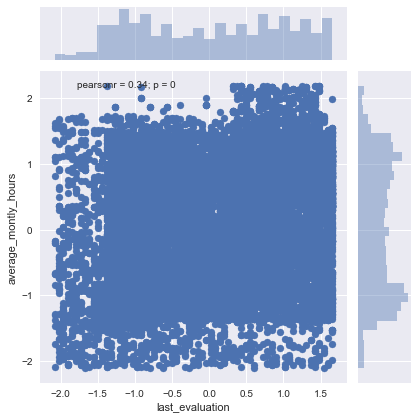

In [41]:
sns.jointplot(X.last_evaluation,X.average_montly_hours);

In [42]:
aux.corr()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000


In [43]:
X.loc[:,['satisfaction_level', 'last_evaluation','number_project','average_montly_hours','time_spend_company']].corr()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company
satisfaction_level,1.000000,0.105021,-0.142970,-0.020048,-0.100866
last_evaluation,0.105021,1.000000,0.349333,0.339742,0.131591
number_project,-0.142970,0.349333,1.000000,0.417211,0.196786
average_montly_hours,-0.020048,0.339742,0.417211,1.000000,0.127755
time_spend_company,-0.100866,0.131591,0.196786,0.127755,1.000000


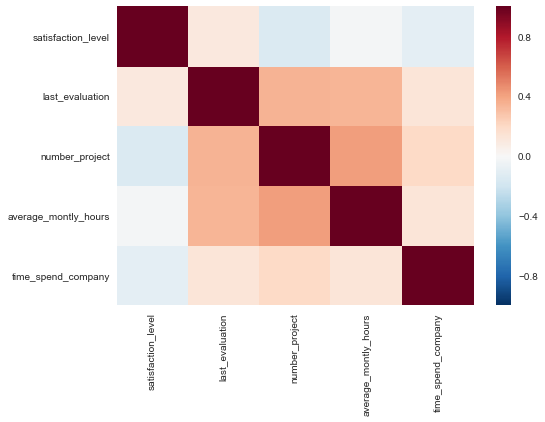

In [44]:
sns.heatmap(X.loc[:,['satisfaction_level', 'last_evaluation','number_project','average_montly_hours','time_spend_company']].corr());

### Análisis de la correlación entre las variables

* Se puede ver claramente como existe una concentración importante de los valores en los cuadrantes superiores. Si bien la correlación no es tan marcada (no es fuerte), si se observa la correlación positiva media que nos entrega el coeficiente de Pearson

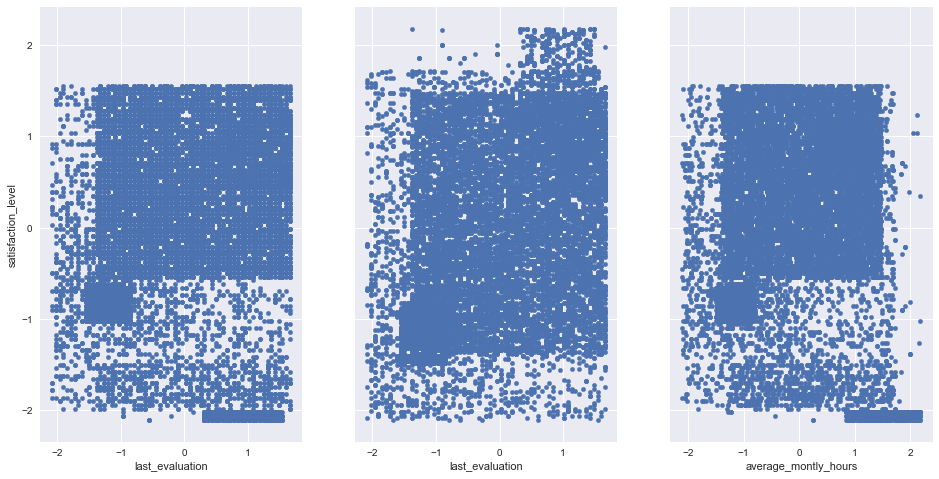

In [45]:
# visualize the relationship between the features and the response using scatterplots
fig, axs = plt.subplots(1, 3, sharey=True)
X.plot(kind='scatter', x='last_evaluation', y='satisfaction_level', ax=axs[0], figsize=(16, 8))
X.plot(kind='scatter', x='last_evaluation', y='average_montly_hours', ax=axs[1],figsize=(16, 8))
X.plot(kind='scatter', x='average_montly_hours', y='satisfaction_level', ax=axs[2],figsize=(16, 8));

### Generamos un dataset balanceado con la técnica de Random Under sample

* Aplicamos la simple técnica de Random Under Sampling para balancear la clase minoritaria con la mayoritaria (fuga vs no fuga) Esta técnica consiste en generar una muestra aleatoria de los registros que tienen la clase mayoritaria como valor en el target con la misma cantidad de datos que la clase minoritaria

* El riesgo de esta técnica es que el muestreo aleatorio no sea suficiente para representar adecuadamente la composicion de los registros de la clase mayoritaria, es por eso que solo la utilizaremos en los algoritmos en donde 

* Para revisar un resumen muy explicativo de las técnicas para balancear clases se recomienda visitar el siguiente link: *<https://www.svds.com/learning-imbalanced-classes/>*

Información del dataset con Random Under Sampling:
 y: Counter({0: 3571, 1: 3571})


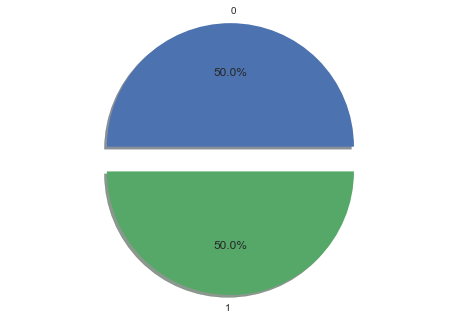

In [46]:
X_us, y_us , index_us= RandomUnderSampler(
    ratio='not minority', random_state=0,return_indices=True
).fit_sample(X, y)
print('Información del dataset con Random Under Sampling:'
      '\n y: {}'.format(Counter(y_us)))
plot_pie(y_us)

In [47]:
%%time
mi = mutual_info_classif(X_us,y_us,random_state=0,discrete_features='auto')

CPU times: user 1.33 s, sys: 20.3 ms, total: 1.35 s
Wall time: 1.37 s


                 features   m-score  m-weight
0      satisfaction_level  0.338460  1.000000
2          number_project  0.246185  0.727368
3    average_montly_hours  0.182331  0.538707
1         last_evaluation  0.143222  0.423159
4      time_spend_company  0.124240  0.367073
5           Work_accident  0.018520  0.054719
7                  salary  0.014370  0.042456
17              technical  0.009128  0.026968
11                     hr  0.008524  0.025186
16                support  0.003845  0.011361
6   promotion_last_5years  0.003073  0.009080
9                   RandD  0.002673  0.007899
12             management  0.001917  0.005664
8                      IT  0.000691  0.002043
13              marketing  0.000446  0.001317
10             accounting  0.000000  0.000000
14            product_mng  0.000000  0.000000
15                  sales  0.000000  0.000000


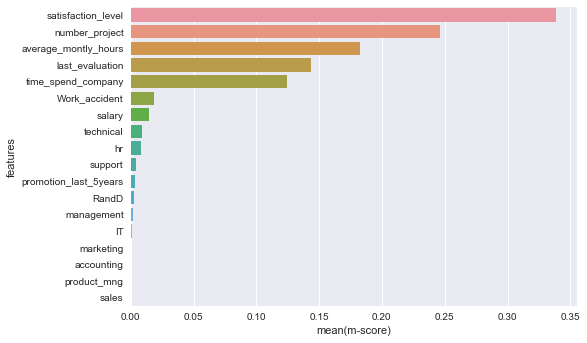

In [48]:
# Creamos el dataframe con los resultados
raw_data={'features':X.columns.values,'m-score':mi,'m-weight':mi/np.max(mi)}
features_mi=pd.DataFrame(raw_data,columns=['features','m-score','m-weight'])
features_mi=features_mi.sort_values(by='m-weight',ascending=False)
print(features_mi)
sns.barplot(x='m-score', y='features', data=features_mi);

## Selección de variables con RFE

* Ahora vamos a usar la técnica de RFE (recursive feature engineer) para seleccionar variables. Esta técnica va ejecutando de forma recursiva el modelo y elimina la variable menos relevante en cada iteración. Con esto se construye un ranking de importancia de variables que permite ordenarlas según su importancia.

* Para aplicar esta técnica es necesario que el modelo tenga como output una estimación de la importancia de variables que sirva para ordenar, en particular usaremos Random Forest, Gradient Boosting y Regresión logística

In [49]:
%%time
clf = RandomForestClassifier(
    bootstrap=True, criterion='gini',max_features='sqrt',min_samples_split=50,
    n_estimators=500,random_state=0,warm_start=True,n_jobs=-1, min_samples_leaf =50)
#class_weight='balanced'
#clf.fit(X_us, y_us)
rfe_rf = RFE(clf, n_features_to_select=1)
fit_rf = rfe_rf.fit(X_us, y_us)

CPU times: user 54.1 s, sys: 4.47 s, total: 58.6 s
Wall time: 35.7 s


In [50]:
raw_data={'features':X.columns.values,'ranking_ffe_rf':fit_rf.ranking_}
features_ffe_rf=pd.DataFrame(
    raw_data,columns=['features','ranking_ffe_rf']).sort_values(by='ranking_ffe_rf',ascending=True)
selected_features=pd.merge(left=features_mi,right=features_ffe_rf, how='left', on='features', 
                           sort=False,suffixes=('_mi', '_ffe_rf'), copy=True, indicator=False)
selected_features.sort_values(by='ranking_ffe_rf',ascending=True)

,features,m-score,m-weight,ranking_ffe_rf
0,satisfaction_level,0.338460,1.000000,1
4,time_spend_company,0.124240,0.367073,2
1,number_project,0.246185,0.727368,3
2,average_montly_hours,0.182331,0.538707,4
3,last_evaluation,0.143222,0.423159,5
5,Work_accident,0.018520,0.054719,6
6,salary,0.014370,0.042456,7
7,technical,0.009128,0.026968,8
17,sales,0.000000,0.000000,9
10,promotion_last_5years,0.003073,0.009080,10


In [51]:
%%time
# Extracción de variables con RFE
model = LogisticRegression(random_state=0,warm_start=True)
rfe_lr = RFE(model, n_features_to_select=1)
fit_rl = rfe_lr.fit(X_us, y_us)

CPU times: user 287 ms, sys: 12.4 ms, total: 299 ms
Wall time: 340 ms


In [52]:
raw_data={'features':X.columns.values,'ranking_ffe_rl':fit_rl.ranking_}
features_ffe_rl=pd.DataFrame(
    raw_data,columns=['features','ranking_ffe_rl']).sort_values(by='ranking_ffe_rl',ascending=True)
selected_features=pd.merge(left=selected_features,right=features_ffe_rl, how='left', on='features', left_on=None, 
                           sort=False,suffixes=('', '_ffe_rl'), copy=True, 
                           indicator=False)
selected_features.sort_values(by='ranking_ffe_rl',ascending=True)

,features,m-score,m-weight,ranking_ffe_rf,ranking_ffe_rl
10,promotion_last_5years,0.003073,0.009080,10,1
5,Work_accident,0.018520,0.054719,6,2
0,satisfaction_level,0.338460,1.000000,1,3
6,salary,0.014370,0.042456,7,4
12,management,0.001917,0.005664,11,5
4,time_spend_company,0.124240,0.367073,2,6
11,RandD,0.002673,0.007899,13,7
1,number_project,0.246185,0.727368,3,8
3,last_evaluation,0.143222,0.423159,5,9
8,hr,0.008524,0.025186,14,10


In [53]:
%%time
# Extracción de variables con RFE
model = GradientBoostingClassifier(
    random_state=0,max_features='sqrt',subsample=0.8,
    learning_rate=0.01, max_depth=5,n_estimators=500,
    min_samples_split = 70,warm_start=True,presort=True)
rfe_gb = RFE(model, n_features_to_select=1)
fit_gb = rfe_gb.fit(X=X_us, y=y_us)

CPU times: user 46.2 s, sys: 816 ms, total: 47.1 s
Wall time: 49.6 s


In [54]:
raw_data={'features':X.columns.values,'ranking_ffe_gb':fit_gb.ranking_}
features_ffe_gb=pd.DataFrame(
    raw_data,columns=['features','ranking_ffe_gb']).sort_values(by='ranking_ffe_gb',ascending=True)
selected_features=pd.merge(left=selected_features,right=features_ffe_gb, how='left', on='features',
                           suffixes=('', '_ffe_gb'), copy=True, indicator=False)
selected_features.sort_values(by='ranking_ffe_gb',ascending=True)

,features,m-score,m-weight,ranking_ffe_rf,ranking_ffe_rl,ranking_ffe_gb
0,satisfaction_level,0.338460,1.000000,1,3,1
4,time_spend_company,0.124240,0.367073,2,6,2
2,average_montly_hours,0.182331,0.538707,4,11,3
1,number_project,0.246185,0.727368,3,8,4
3,last_evaluation,0.143222,0.423159,5,9,5
6,salary,0.014370,0.042456,7,4,6
5,Work_accident,0.018520,0.054719,6,2,7
16,product_mng,0.000000,0.000000,15,18,8
7,technical,0.009128,0.026968,8,13,9
8,hr,0.008524,0.025186,14,10,10


### Usando linear suport vector classification

* Se utiliza el algoritmo linear suport vector classification con penalización l1 para estimar los coeficientes y un coeficiente de 0.005, los cuales son llevados a valor absoluto para luego ser rankeados en orden de importancia

*<http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html>*

*<https://datascience.stackexchange.com/questions/6987/can-you-explain-the-difference-between-svc-and-linearsvc-in-scikit-learn>*

*<https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/>*

In [55]:
%%time
lsvc = LinearSVC(C=0.01, penalty="l1", random_state=0,dual=False,
                 loss='squared_hinge').fit(X_us, y_us)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_us)
print(X_new.shape)

(7142, 10)
CPU times: user 11.3 ms, sys: 2.49 ms, total: 13.7 ms
Wall time: 12.2 ms


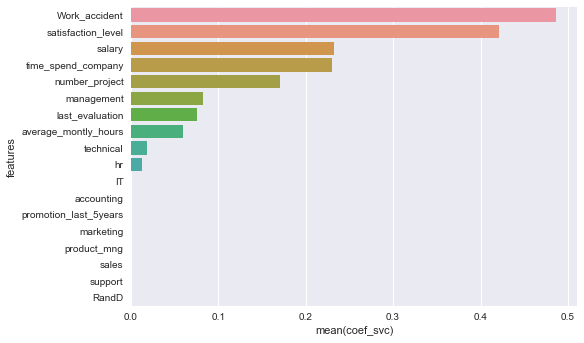

In [56]:
raw_data={'features':X.columns.values,'coef_svc':np.abs(lsvc.coef_[0])}
features_svc=pd.DataFrame(raw_data,columns=['features','coef_svc']).sort_values(by='coef_svc',ascending=False)
features_svc['ranking_svc']=range(1,len(lsvc.coef_[0])+1)
sns.barplot(x='coef_svc', y='features', data=features_svc);

In [57]:
selected_features=pd.merge(left=selected_features,right=features_svc, how='left', on='features',
                           sort=False,suffixes=('', '_svc_lineal'), copy=True, indicator=False)
selected_features.sort_values(by='ranking_ffe_gb',ascending=True)

,features,m-score,m-weight,ranking_ffe_rf,ranking_ffe_rl,ranking_ffe_gb,coef_svc,ranking_svc
0,satisfaction_level,0.338460,1.000000,1,3,1,0.421292,2
4,time_spend_company,0.124240,0.367073,2,6,2,0.230606,4
2,average_montly_hours,0.182331,0.538707,4,11,3,0.059782,8
1,number_project,0.246185,0.727368,3,8,4,0.170335,5
3,last_evaluation,0.143222,0.423159,5,9,5,0.075684,7
6,salary,0.014370,0.042456,7,4,6,0.232960,3
5,Work_accident,0.018520,0.054719,6,2,7,0.486076,1
16,product_mng,0.000000,0.000000,15,18,8,0.000000,15
7,technical,0.009128,0.026968,8,13,9,0.018115,9
8,hr,0.008524,0.025186,14,10,10,0.012687,10


## Principales conclusiones

* Utilizando los análisis estadísticos realizados en el EDA, los resultados presentados en la última tabla y algunos criterios de negocio que se explican más abajo, seleccionamos las siguientes variables:

     * nivel de satisfacción
     * tiempo en la compañia
     * Número de proyectos en los que ha participado
     * número de horas trabajas promedio mensualmente en los últimos 12 meses
     + última evaluación
     * Salario
     * Promovido en los últimos 5 años
     * Managment
   
##### ¿Por qué dejamos la variable última evaluación?

* Argumentos para descartar la variable última evaluación porque: 
    
    * Si observamos su distribución según valor del target, podemos ver que es bastante similar y, en promedio, no
    presenta diferencias (0.71 ambos) y sus desviaciones son muy similares (0.16 vs 0.19)
    
    * Es una variable que está positiva y medianamente correlacionada con las variables de número de proyectos en 
    que ha participado (0.35) y número de horas que ha trabajado en promedio en los últimos 12 meses (0.34), por lo 
    cual la información que entrega es posible que ya esté contenida en estas variables y causemos un problema de 
    multicolinealidad en el modelo de regresión logística
    

* Argumentos para no descartar la variable última evaluación:
    
    * Aparece consistentemente dentro de las primeras 10, en los modelos de árboles dentro de las primeras 5 y 
    tiene un alto m-score
    
    * Al graficar en el scatter plot esta variable con las variables con las cuales tiene correlación media, 
    podemos ver que si bien existe concentración en los cuadrantes superiores, la distribución de puntos es 
    bastante homogenea y no en todos los casos hay una correlación clara

##### ¿Por qué no descartamos la variable número de horas trabajas promedio mensualmente en los últimos 12 meses?

* A pesar de que está medianamente correlacionada con el número de proyectos en los cuales ha trabajado (0.42), no es posible establecer que contiene la misma información, ya que el número de horas trabajadas por proyecto puede diferir en función de varias variables como:
    * Eficiencia de la persona
    * Requerimientos de cada proyecto
    * Funciones específicas de la persona dentro del proyecto

##### ¿Por qué descartamos la variable binaria que establece si ha tenido o no un accidente en el trabajo?

* Utilizamos un criterio de negocio para descartar la variable de accidente en el trabajo, a pesar de que obtiene un buen ranking en todas las evaluaciones. Nuestra hipótesis es que se trata de un falso predictor .Si observamos cómo se distribuye esta según valor del target, podemos ver que hay que la proporción de accidentes es mayor en las personas que se quedan que en las que se van.Esto se puede presentar por varias razones, pero es poco razonable pensar que una de las razones para no irse es no tener accidentes en el trabajo o bien que una de las razones para quedarse es tener más accidentes en el trabajo.

##### ¿Por qué descartamos la variable hr y decidimos mantener las de managment y si fue promovido en los últimos 5 años o no?

* Hay tres variables con resultados dispares al aplicar RFE pero que hemos visto variación relevante en cuanto a su distribución según empleados fugados o no fugados y además hemos rechazado su independencia con respecto al target con un 99% de confianza utilizando el test chi2: Managment,hr y promovido en los últimos 5 años. 

* La primera, managment, aparece como variable relevante en ambos modelos lineales pero con un puntaje bajo en m-score y en los últimos lugares en los modelos de árboles.La segunda, hr, aparece en el número 10 de los modelos lineales y GB, pero en casi al final en RF. Para decidir incluir estas variables deberíamos tomar un criterio de negocio y establecer basados en las características del mercado laboral del cual provienen los datos (el cual es desconocido) que los cargos de managment rotan menos y que los cargos de recursos humanos más

* Con respecto a la última, aparece como la más relevante en regresión logística y en la parte media para RF(10) y GB(11), pero con un m-score bajo e irrelevante en SVC lineal. Sin embargo, decidimos incluirla por:

    * Su marcada diferencia en cuanto a la distribución entre los que se fugan y no, además del sentido de negocio 
    que tiene el que una persona que no es promovida luego de 5 años, en conjunto con otros factores (evaluación de 
    desempeño,salario,etc) comience a buscar otras oportunidades
    
    * Es posible que SVC lineal no haya detectado relevancia en la variable última evaluació porque no puede 
    encontrar el vector de separación de forma lineal y habría que usar una variación de este o relajar la 
    penalización para que lo encuentre (subir el parámetro C)
    
    * Fuentes utilizadas:
    
    *<http://www.estadistica.net/ECONOMETRIA/CUALITATIVAS/LOGISTICA/regresion-logistica.pdf>*
    
    *<https://github.com/rasbt/python-machine-learning-book/blob/master/faq/select_svm_kernels.md>*

##### ¿Por qué descartamos el resto de las variables?

* El resto de las variables está consistentemente evaluada por debajo de las primeras 10 en todos los algoritmos, con puntajes bajos (o nulos) en mi-score y/o coeficiente del svc, y/o una mezcla de ambos.